In [18]:
%matplotlib inline
from __future__ import print_function
import numpy as np
import numpy.random as npr
import pandas as pd

df = pd.read_excel("CHOPER_IBAQ_sep.xlsx",header=0,index_col=0)
df.loc["Day",:] = df.loc["Day",:].apply(int)
# Replace 0 with NaN
df.replace([np.inf, -np.inf,0.0], np.nan)
df.dropna(inplace=True,axis=0)

df


,iBAQ 1 (Day 3 r1),iBAQ 2 (Day 3 r2),iBAQ 3 (Day 3 r3),iBAQ 4 (Day 5 r1),iBAQ 5 (Day 5 r2),iBAQ 6 (Day 5 r3),iBAQ 7 (Day 10 r1),iBAQ 8 (Day 10 r2),iBAQ 9 (Day 10 r3),iBAQ 10 (Day 12 r1),...,iBAQ 42 (Day 39 r3),iBAQ 43 (Day 40 r1),iBAQ 44 (Day 40 r2),iBAQ 45 (Day 40 r3),iBAQ 46 (Day 41 r1),iBAQ 47 (Day 41 r2),iBAQ 48 (Day 41 r3),iBAQ 49 (Day 45 r1),iBAQ 50 (Day 45 r2),iBAQ 51 (Day 45 r3)
Protein IDs,,,,,,,,,,,,,,,,,,,,,
Day,3.000000e+00,3.000000e+00,3.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,10.0,10.0,10.0,12.0,...,3.900000e+01,4.000000e+01,4.000000e+01,4.000000e+01,4.100000e+01,4.100000e+01,4.100000e+01,4.500000e+01,4.500000e+01,4.500000e+01
CON__Q3MHN5;CON__ENSEMBL:ENSBTAP00000018229,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.663600e+05,0.000000e+00,0.0,0.0,0.0,0.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
CON__ENSEMBL:ENSBTAP00000038253,0.000000e+00,0.000000e+00,1.534900e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
CON__P00761,2.388700e+09,3.080300e+09,3.022600e+09,2.878500e+09,2.832100e+09,2.674700e+09,837270000.0,478160000.0,656560000.0,743860000.0,...,2.065000e+09,1.440400e+09,2.167600e+09,2.618300e+09,2.933300e+09,1.424800e+09,2.518100e+09,3.003700e+09,1.504400e+09,1.563300e+09
CON__P02533;tr|G3I8F9|G3I8F9_CRIGR;CON__Q6IFX2;tr|G3I8G1|G3I8G1_CRIGR;CON__A2A4G1;CON__P08727;tr|G3I8F7|G3I8F7_CRIGR;CON__P19001;CON__Q61782;tr|G3INZ7|G3INZ7_CRIGR;CON__P35900;CON__Q9D312;CON__P05784;CON__Q99456;tr|G3IPB6|G3IPB6_CRIGR;tr|G3IPJ0|G3IPJ0_CRIGR;tr|G3HX38|G3HX38_CRIGR;tr|G3IPC7|G3IPC7_CRIGR;CON__Q8N1A0;CON__Q14525;CON__Q9UE12;CON__Q15323;CON__A2A5Y0;CON__Q14532;CON__A2AB72;CON__Q497I4;CON__O76015;CON__O76013;CON__Q7Z3Y9;CON__O76014;CON__REFSEQ:XP_986630;tr|G3I8F3|G3I8F3_CRIGR;tr|G3I8F1|G3I8F1_CRIGR,3.406000e+06,4.858500e+06,5.641600e+06,6.155600e+06,7.301600e+06,5.504800e+06,1560600.0,995070.0,1838200.0,0.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.326300e+05,5.457200e+05,0.000000e+00,0.000000e+00,0.000000e+00
CON__P02538;CON__O95678;CON__Q8VED5;tr|G3IBN7|G3IBN7_CRIGR;CON__H-INV:HIT000292931,7.718300e+06,6.341900e+06,8.328300e+06,9.096000e+06,1.770000e+07,1.688100e+07,4939500.0,2118300.0,2697100.0,0.0,...,3.245600e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.792500e+05,1.463800e+06,0.000000e+00,0.000000e+00,0.000000e+00
CON__P02584,7.714300e+06,1.489900e+07,1.597800e+07,1.149600e+07,1.468500e+07,1.289000e+07,25877000.0,15524000.0,18421000.0,46641000.0,...,3.169300e+07,3.816200e+07,2.528900e+07,3.317700e+07,5.432100e+07,1.973000e+07,2.618100e+07,1.934100e+07,6.681400e+06,7.270400e+06
CON__P02662,1.516100e+07,1.860800e+07,1.401700e+07,2.632300e+07,1.807900e+07,2.021200e+07,0.0,2232800.0,0.0,2139400.0,...,1.355000e+07,3.048700e+06,2.861100e+06,3.835900e+06,0.000000e+00,0.000000e+00,0.000000e+00,6.343600e+06,2.381800e+06,6.802500e+06
CON__P02663,2.017900e+06,1.453400e+06,1.449900e+06,2.757700e+06,1.990200e+06,1.142100e+06,300830.0,0.0,0.0,322480.0,...,1.150700e+06,3.649800e+05,6.778300e+05,1.043600e+06,9.627700e+05,4.608600e+05,1.033000e+06,1.577300e+06,3.819100e+05,5.077500e+05


In [3]:
def bootstrap(invec):
    idx = npr.randint(0, len(invec), len(invec))
    return [invec[i] for i in idx]

def estimatePi0(p, numBoot=100, numLambda=100, maxLambda=0.95):
    p.sort()
    n=len(p)
    lambdas=np.linspace(maxLambda/numLambda,maxLambda,numLambda)
    Wls=np.array([n-np.argmax(p>=l) for l in lambdas])
    pi0s=np.array([Wls[i] / (n * (1 - lambdas[i])) for i in range(numLambda)])
    minPi0=np.min(pi0s)
    mse = np.zeros(numLambda)
    for boot in range(numBoot):
        pBoot = bootstrap(p)
        pBoot.sort()
        WlsBoot =np.array([n-np.argmax(pBoot>=l) for l in lambdas])
        pi0sBoot =np.array([WlsBoot[i] / (n *(1 - lambdas[i])) for i in range(numLambda)])
        mse = mse + np.square(pi0sBoot-minPi0)
    minIx = np.argmin(mse)
    return pi0s[minIx]

def qvalues(pvalues):
    m=len(pvalues)
    pvalues.sort()
    pi0 = estimatePi0([p for p,coord in pvalues])
    num_p, p_sum, qs = 0.0, 0.0, []
    for p,coord in pvalues:
        num_p += 1.0
        p_sum += p
        q = pi0*p*m/num_p
        qs.append((q,p,coord))
    qs.reverse()
    old_q=1.0
    for ix in range(len(qs)):
        q = min(old_q,qs[ix][0])
        old_q = q
        qs[ix] = (q,qs[ix][1],qs[ix][2])
    qs.reverse()
    return qs

In [4]:
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

days,pv = [],[]
for name,values in df.iterrows():
    if name == "Day":
        days = values.apply(int)
        continue
    analys_df = pd.DataFrame({"Day": days.values, "Expression" : values.values},index=df.columns)
    analys_df.dropna(inplace=True,axis=0)
    analys_df.drop(analys_df.loc[(analys_df.loc[:,"Expression"]==0.0)].index,inplace=True,axis=0)
    uniq_days = set(analys_df.loc[:,"Day"])
    if analys_df.shape[0]<2*len(uniq_days) or len(uniq_days)<=3:
        continue
#    model = ols("Expression ~ C(Day)",analys_df).fit()
    model = ols("Expression ~ Day",analys_df).fit()
    report = anova_lm(model,type=2)
    p = report.loc["Day","PR(>F)"]
    pv.append((p,name))
    if np.isnan(p):
        print(report)
        print(analys_df)
        break
qv = qvalues(pv)
    

/usr/local/lib/python2.7/dist-packages/scipy/stats/_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/usr/local/lib/python2.7/dist-packages/scipy/stats/_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/usr/local/lib/python2.7/dist-packages/scipy/stats/_distn_infrastructure.py:1814: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


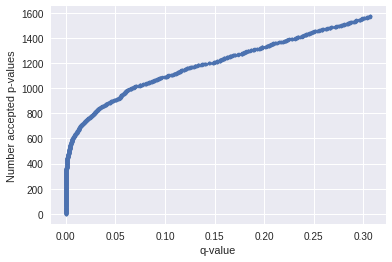

In [5]:
import matplotlib.pyplot as plt
plt.plot([q[0] for q in qv],range(len(qv)),'b.')
plt.ylabel("Number accepted p-values")
plt.xlabel("q-value")
#plt.xlim(0,0.1)
#plt.ylim(0,1800)
plt.show()

RuntimeError: maximum recursion depth exceeded while getting the str of an object

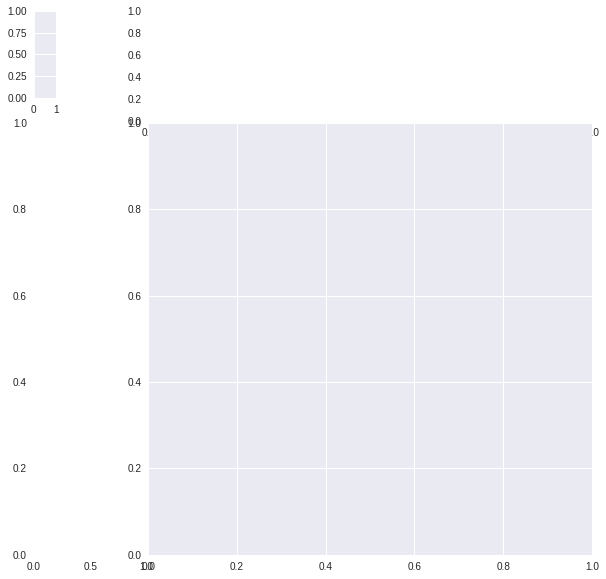

In [19]:
import seaborn as sns; sns.set(color_codes=True)

g = sns.clustermap(df,metric="cosine",method='single')


In [28]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.cluster as cluster
import time
sns.set_context('poster')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}

def plot_clusters(data, algorithm, args, kwds):
    start_time = time.time()
    labels = algorithm(*args, **kwds).fit_predict(data.values.T)
    end_time = time.time()
    palette = sns.color_palette('deep', np.unique(labels).max() + 1)
    colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in labels]
    plt.scatter(np.log(data.iloc[:,3]), np.log(data.iloc[:,50]), c=colors, **plot_kwds)
    frame = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)
    plt.title('Clusters found by {}'.format(str(algorithm.__name__)), fontsize=24)
    plt.text(-0.5, 0.7, 'Clustering took {:.2f} s'.format(end_time - start_time), fontsize=14)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:16: RuntimeWarning: divide by zero encountered in log


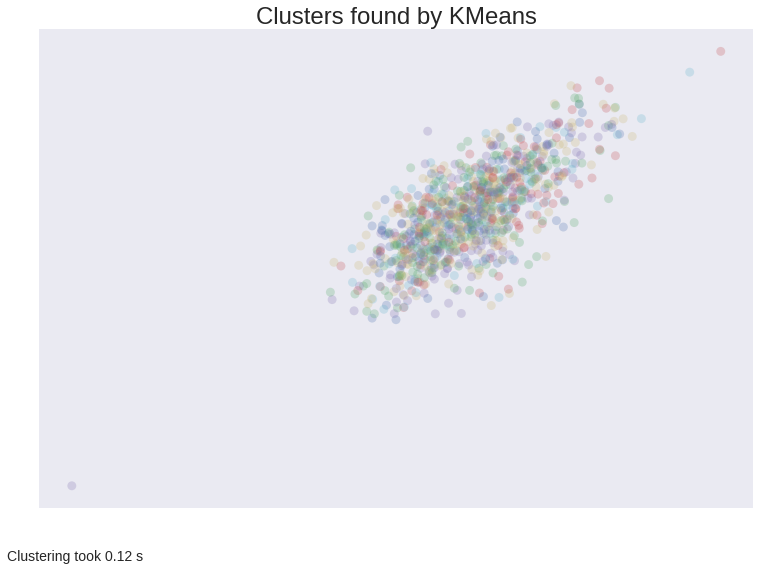

In [29]:
plot_clusters(df, cluster.KMeans, (), {'n_clusters':6})

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:16: RuntimeWarning: divide by zero encountered in log


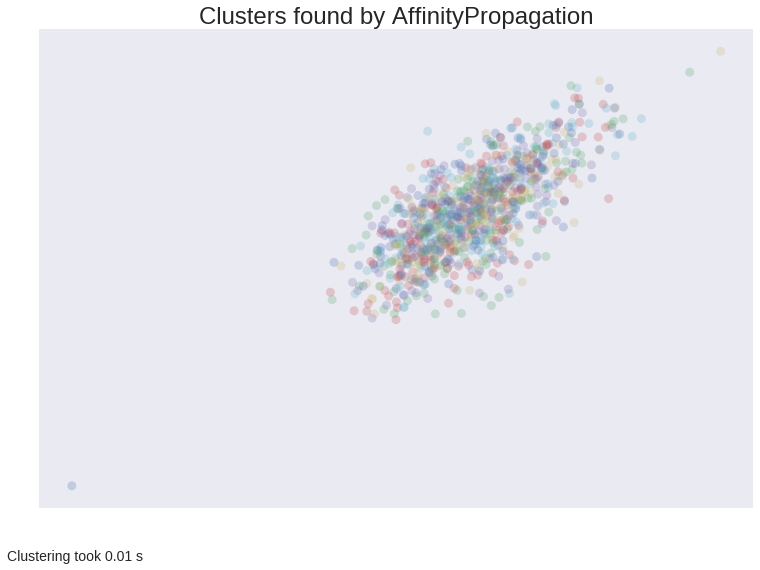

In [30]:
plot_clusters(df, cluster.AffinityPropagation, (), {'preference':-5.0, 'damping':0.95})

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:16: RuntimeWarning: divide by zero encountered in log


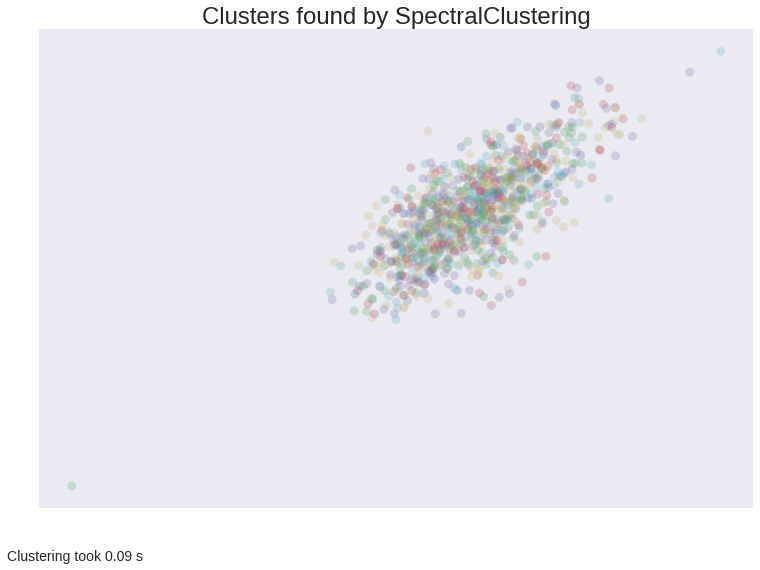

In [31]:
plot_clusters(df, cluster.SpectralClustering, (), {'n_clusters':6})

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:16: RuntimeWarning: divide by zero encountered in log


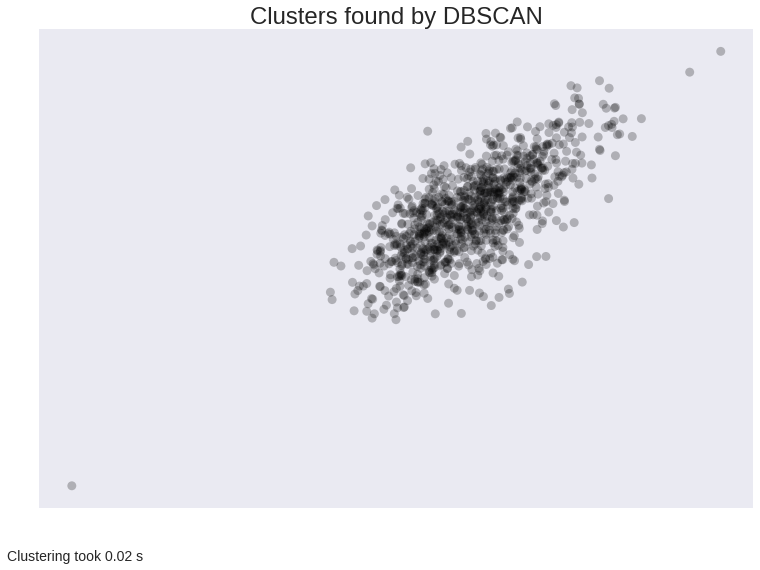

In [32]:
plot_clusters(df, cluster.DBSCAN, (), {'eps':0.025})